# Part A
You should only need to run this once, after that can simply load in the saved images as done in part B.

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image, ImageOps
Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import random
import numpy as np
import os

In [22]:
%matplotlib widget

# Open the .tif file
img = Image.open("C:/Users/14041/Documents/GitHub/DATA3888_Image_Group_2/Biotechnology2/data_processed/morphology_focus.tif")


# Convert to numpy array
image_array = np.array(img)

# Calculate the quantile to scale intensity
quantile_value = np.quantile(image_array, 0.99)

# Scale intensity by dividing by the quantile
scaled_image_array = image_array / quantile_value

# Clip values greater than 1 to ensure image is within [0, 1] range
img2 = np.clip(scaled_image_array, 0, 1)

# Display the scaled image
# plt.imshow(img2, cmap='gray')  # Uncomment this line and below to display the whole image (this runs slow)
# plt.show()

In [23]:
cell_boundaries = pd.read_csv("C:/Users/14041/Documents/GitHub/DATA3888_Image_Group_2/Biotechnology2/data_processed/cell_boundaries.csv.gz")
cell_boundaries['vertex_x_trans'] = cell_boundaries['vertex_x'].apply(lambda x: int(x/0.2125))
cell_boundaries['vertex_y_trans'] = cell_boundaries['vertex_y'].apply(lambda x: int(x/0.2125))

In [24]:
clusters = pd.read_csv("C:/Users/14041/Documents/GitHub/DATA3888_Image_Group_2/Biotechnology2/data_processed/clusters.csv")
ncells = clusters.shape[0]
ncells

36553

In [25]:
img_pix = np.array(img)

In [36]:
random.seed(2024)

ncells_subset = 1000

cells_subset = random.sample(range(ncells), ncells_subset)

# clusters.loc[cells_subset, "Cluster"]

for i in cells_subset:
    # extract the boundary vertices for the selected cell
    bounds_i = cell_boundaries.loc[cell_boundaries["cell_id"] == i]

    # extract the cluster value for the selected cell
    clustval_i = clusters.loc[i,"Cluster"]

    # extract the pixel intensities for the area covering the cell boundary
    img_sub = img_pix[min(bounds_i["vertex_y_trans"]):max(bounds_i["vertex_y_trans"]),
                min(bounds_i["vertex_x_trans"]):max(bounds_i["vertex_x_trans"])]

    # normalise the pixel intensities according to 99th percentile
    img_sub_norm = img_sub/np.quantile(img_sub, 0.99)

    # as an example, display the image for the first selected cell
    if i in cells_subset[0:5]:
        print(f'Displaying image for cell {i}')
        # plt.imshow(img_sub_norm, cmap="gray")  # Uncomment this line and below to display sample cell images
        # plt.show()

    # create directory for images if it doesn't exist
    cell_dir = os.path.join(os.getcwd(), 'C:/Users/14041/Documents/GitHub/DATA3888_Image_Group_2/Biotechnology2/data_processed/cell_images_py')
    if not os.path.exists(cell_dir):
        os.mkdir(cell_dir)

    # create directory for cluster if it doesn't exist
    clust_dir = os.path.join(cell_dir, f'cluster_{clustval_i}')
    if not os.path.exists(clust_dir):
        os.mkdir(clust_dir)

    # save extracted image as a png file
    plt.imsave(os.path.join(clust_dir, f'cell_{i}.png'), img_sub_norm, cmap="gray")

Displaying image for cell 30807
Displaying image for cell 11908
Displaying image for cell 19906
Displaying image for cell 13120
Displaying image for cell 26875


In [39]:
img_sub_norm

array([[ 53,  41,  47, ..., 102,  87,  87],
       [ 43,  50,  55, ...,  64,  59,  81],
       [ 36,  68,  49, ...,  54,  64,  54],
       ...,
       [ 33,  51,  34, ..., 832, 759, 645],
       [ 34,  40,  36, ..., 829, 763, 671],
       [ 42,  46,  42, ..., 806, 762, 697]], dtype=uint16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


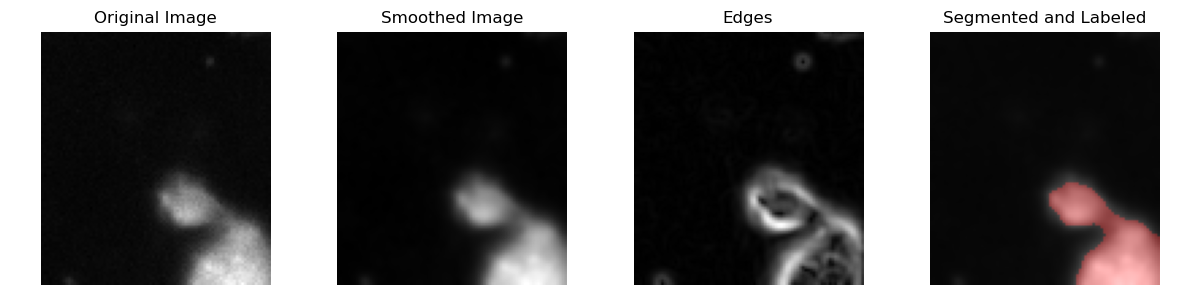

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from skimage import filters, measure, morphology, segmentation, color


# Apply a Gaussian filter for smoothing (reduce noise)
img_sub_smooth = filters.gaussian(img_sub_norm, sigma=1)

# Edge detection using Sobel filter
edges = filters.sobel(img_sub_smooth)

# Segmentation using Otsu thresholding
threshold_value = filters.threshold_otsu(img_sub_smooth)
segmented = img_sub_smooth > threshold_value

# Morphological operations for cleaning up the segmentation
cleaned = morphology.remove_small_objects(segmented, min_size=50)
cleaned = morphology.closing(cleaned, morphology.disk(4))

# Label the objects (cells)
labels = measure.label(cleaned)

# Color the labels to visually distinguish different objects
colored_labels = color.label2rgb(labels, image=img_sub_smooth, bg_label=0)



# Display the original and processed images side-by-side
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax[0].imshow(img_sub_norm, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(img_sub_smooth, cmap='gray')
ax[1].set_title('Smoothed Image')
ax[2].imshow(edges, cmap='gray')
ax[2].set_title('Edges')
ax[3].imshow(colored_labels)
ax[3].set_title('Segmented and Labeled')

for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

# Part B

### Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image, ImageOps
Image.MAX_IMAGE_PIXELS = None
import pandas as pd
import random 
import numpy as np
import os
import re

In [2]:
DATA_DIRECTORY = os.path.abspath('C:/Users/14041/Documents/GitHub/DATA3888_Image_Group_2/Biotechnology2/data_processed')
CELL_IMAGES = os.path.join(DATA_DIRECTORY, 'cell_images_py')
SIZE=(50, 50)

## Loading in and displaying images

In [3]:
def get_cluster_images(cluster: int, size=(None, None)):
    DIR = os.path.join(CELL_IMAGES, f'cluster_{cluster}')
    files = [os.path.join(DIR, file) for file in os.listdir(DIR)]
    return [Image.open(file).convert("L") if None in size else Image.open(file).convert("L").resize(size) for file in files]

In [4]:
# cluster_A_files = os.path.join(CELL_IMAGES, os.listdir(os.path.join(CELL_IMAGES, 'cluster_8')))
cluster_A_files = [os.path.join(os.path.join(CELL_IMAGES, 'cluster_8'), file) for file in os.listdir(os.path.join(CELL_IMAGES, 'cluster_8'))]
cluster_B_files = [os.path.join(os.path.join(CELL_IMAGES, 'cluster_13'), file) for file in os.listdir(os.path.join(CELL_IMAGES, 'cluster_13'))]

In [5]:
cluster_A_images = get_cluster_images(8)
cluster_B_images = get_cluster_images(13)
cluster_A_images_resized = get_cluster_images(8, size=SIZE)
cluster_B_images_resized = get_cluster_images(13, size=SIZE)

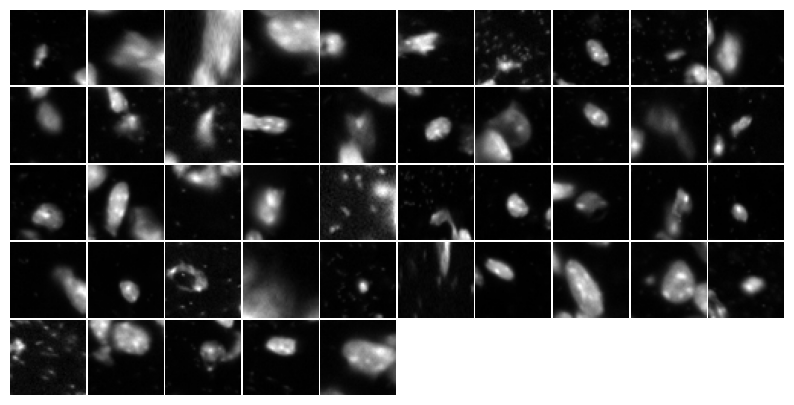

In [6]:
def display_images_in_grid(images, ncols=3, cmap=None):
    nrows = (len(images) + ncols - 1) // ncols
    fig_height = nrows * 1  # Adjust the multiplier as needed to control spacing between rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, fig_height))

    for ax in axes.flat:
        ax.axis('off')

    for i, image in enumerate(images):
        ax = axes[i // ncols, i % ncols]
        if not cmap:
            ax.imshow(image)
        else:
            ax.imshow(image, cmap=cmap)

    plt.subplots_adjust(wspace=0.01, hspace=0.03)  # Adjust spacing between subplots
    plt.show()

display_images_in_grid(cluster_A_images_resized, ncols=10, cmap='gray')

## Cell boundary and masking

### Setup

In [7]:
from shapely.geometry import Polygon
import rasterio
from rasterio.features import geometry_mask
from skimage.draw import polygon2mask

C:\Users\14041\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
cell_boundaries_raw = pd.read_csv("C:/Users/14041/Documents/GitHub/DATA3888_Image_Group_2/Biotechnology2/data_processed/cell_boundaries.csv.gz")

def get_cluster_cell_ids(cluster: int):
    DIR = os.path.join(CELL_IMAGES, f'cluster_{cluster}')
    files = [os.path.join(DIR, file) for file in os.listdir(DIR)]
    pattern = r'cell_(\d+)\.png'
    return [int(re.search(pattern, file).group(1)) for file in files]


cluster_A_cell_ids = get_cluster_cell_ids(8)
cluster_B_cell_ids = get_cluster_cell_ids(13)

### Masking one cell

In [9]:
cell_boundaries = cell_boundaries_raw.loc[cell_boundaries_raw['cell_id'].isin(cluster_A_cell_ids + cluster_B_cell_ids)]

In [10]:
def get_masked_image(image: Image, cell_id: int, cell_boundaries: pd.core.frame.DataFrame):
    height, width = np.array(image).shape
    cell_boundary = cell_boundaries[cell_boundaries['cell_id'] == cell_id].copy()
    cell_boundary['vertex_x_scaled'] = 1 + ((cell_boundary['vertex_x'] - cell_boundary['vertex_x'].min()) * scaling_factor)
    cell_boundary['vertex_y_scaled'] = 1 + ((cell_boundary['vertex_y'] - cell_boundary['vertex_y'].min()) * scaling_factor)
    polygon = np.array(list(zip(cell_boundary['vertex_y_scaled'], cell_boundary['vertex_x_scaled'])))
    mask = polygon2mask((height, width), polygon)
    masked_image = np.ma.masked_array(np.copy(img_A),  np.invert(mask), fill_value=0)
    return masked_image

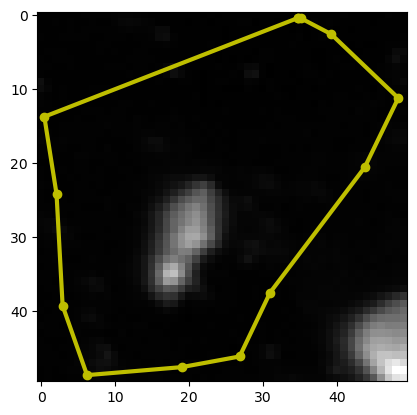

In [11]:
index = 0

cell_boundary = cell_boundaries[cell_boundaries['cell_id'] == cluster_A_cell_ids[index]].copy()
img_A = cluster_A_images[index].convert("L")
img_A_resized = cluster_A_images_resized[index].convert("L")

# Calculate scaling factor
scaling_factor = 1 / 0.22
height, width = np.array(img_A).shape

# Calculate scaled x and y coordinates
cell_boundary['vertex_x_scaled'] = (1 + ((cell_boundary['vertex_x'] - cell_boundary['vertex_x'].min()) * scaling_factor))*50/width
cell_boundary['vertex_y_scaled'] = (1 + ((cell_boundary['vertex_y'] - cell_boundary['vertex_y'].min()) * scaling_factor))*50/height

# Visualize the image
plt.clf()
plt.close()
plt.imshow(img_A_resized, cmap='gray')
plt.plot(cell_boundary['vertex_x_scaled'], cell_boundary['vertex_y_scaled'], 'y-o', linewidth=3)
plt.show()

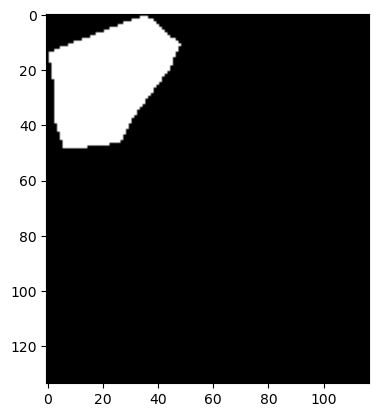

In [12]:
height, width = np.array(img_A.convert("L")).shape
polygon = np.array(list(zip(cell_boundary['vertex_y_scaled'], cell_boundary['vertex_x_scaled'])))
mask = polygon2mask((height, width), polygon)
masked_image = np.ma.masked_array(np.copy(img_A),  np.invert(mask), fill_value=0)

# Display the masked image
# result = np.where(masked_image.mask, 0, masked_image)  # image with mask
result = np.where(masked_image.mask, 0, 1)  # just the mask
plt.imshow(result, cmap='gray')
plt.show()


### Masking all cells

In [13]:
def get_cluster_masked_images(cluster: int, size=(None, None)):
    images = get_cluster_images(cluster)
    if None not in size:   # get resized images if size is specified
        images_resized = get_cluster_images(cluster, size)
        
    cell_ids = get_cluster_cell_ids(cluster)
    cell_boundaries = cell_boundaries_raw.loc[cell_boundaries_raw['cell_id'].isin(cell_ids)].copy()
    
    # Calculate scaling factor
    scaling_factor = 1 / 0.22


    result = {}
    for cell_id, image, image_resized in zip(cell_ids, images, images_resized):
        # get shape of original image (without resize)
        height, width = np.array(image).shape
        # scaling factor for cell boundary, only if size is given
        resize_x = 50/width if None not in size else 1
        resize_y = 50/height if None not in size else 1
        
        # get cell boundary coordinates for the image
        cell_boundary = cell_boundaries.loc[cell_boundaries['cell_id'] == cell_id].copy()
        # Calculate scaled x and y coordinates
        cell_boundary['vertex_x_scaled'] = (1 + ((cell_boundary['vertex_x'] - cell_boundary['vertex_x'].min()) * scaling_factor))*resize_x
        cell_boundary['vertex_y_scaled'] = (1 + ((cell_boundary['vertex_y'] - cell_boundary['vertex_y'].min()) * scaling_factor))*resize_y

        # create the mask
        polygon = np.array(list(zip(cell_boundary['vertex_y_scaled'], cell_boundary['vertex_x_scaled'])))
        mask = polygon2mask((height, width) if None in size else SIZE, polygon)
        # mask the image
        masked_image = np.ma.masked_array(np.copy(image if None in size else image_resized),  np.invert(mask), fill_value=0)
        result[cell_id] = np.where(masked_image.mask, 0, masked_image)
        
    return result

In [14]:

masked_cells = {cluster: get_cluster_masked_images(cluster, size=SIZE) for cluster in range(1, 29)}

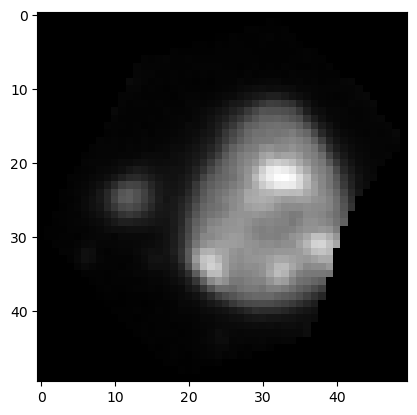

In [15]:
# display_images_in_grid(masked_cells[1])
plt.imshow(masked_cells[8][33839], cmap='gray')

## Deep Learning

In [49]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

### Make the dataset

In [50]:
class CustomDataset(Dataset):
    def __init__(self, images_dict):
        self.images_dict = images_dict
        self.labels = []
        self.images = []
        for cluster, images in images_dict.items():
            self.images.extend(images.values())
            self.labels.extend([cluster-1] * len(images))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert image to PyTorch tensor and normalize if necessary
        image_tensor = torch.tensor(image, dtype=torch.float32) / 255.0
        image_tensor = torch.unsqueeze(image_tensor, 0)
        # Convert label to PyTorch tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
        return image_tensor, label_tensor

#### Load data and create dataloaders

In [51]:
custom_dataset = CustomDataset(masked_cells)

# Define the sizes of the training, validation, and testing sets
train_size = int(0.6 * len(custom_dataset))  # 60% for training
val_size = int(0.2 * len(custom_dataset))    # 20% for validation
test_size = len(custom_dataset) - train_size - val_size  # Remaining for testing

# Split the dataset into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

# Define batch size and other DataLoader parameters
batch_size = 32
shuffle = True

# Create DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

# Create DataLoader for validation set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create DataLoader for testing set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Make the models

#### Random simple model

In [52]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 6 * 6, 128)  # Adjust input size based on your image size
        self.fc2 = nn.Linear(128, num_classes)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(-1, 64 * 6 * 6)  # Adjust input size based on your image size
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Lab 4b Model

In [53]:
class LabModel(nn.Module):
    def __init__(self):
        super(LabModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  # Adjust input size based on your image size
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, 28)  # Assuming 2 classes for binary classification

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(-1, 64 * 12 * 12)  # Adjust input size based on your image size
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout2(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x

#### AlexNet

In [54]:
class AlexNet(nn.Module):
    def __init__(self, num=10):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32*12*12,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,num),
        )

    def forward(self, x):

        x = self.feature(x)
        x = x.view(-1,32*12*12)
        return self.classifier(x)
        # return x

### Train

In [55]:

def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Move model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Lists to store training and validation loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * inputs.size(0)
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # Calculate average training loss and accuracy for the epoch
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        
        # Validation loop
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item() * inputs.size(0)
                
                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
            
        # Calculate average validation loss and accuracy for the epoch
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)
        
        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}, '
              f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}')
    
    # Return training and validation losses and accuracies
    return train_losses, val_losses, train_accuracies, val_accuracies


In [56]:
for images, labels in train_loader:
    print(images.size())
    break

torch.Size([32, 1, 50, 50])


In [57]:
model = LabModel()
t_loss, v_loss, t_acc, v_acc = train_model(model, train_loader, val_loader)
lab_model_results = {
    't_loss': t_loss,
    'v_loss': v_loss,
    't_acc': t_acc,
    'v_acc': v_acc
}

Epoch [1/100], Training Loss: 3.3108, Training Accuracy: 0.0350, Validation Loss: 3.2537, Validation Accuracy: 0.0700
Epoch [2/100], Training Loss: 3.2522, Training Accuracy: 0.0550, Validation Loss: 3.2209, Validation Accuracy: 0.0950
Epoch [3/100], Training Loss: 3.2026, Training Accuracy: 0.0883, Validation Loss: 3.1905, Validation Accuracy: 0.0750
Epoch [4/100], Training Loss: 3.2138, Training Accuracy: 0.0800, Validation Loss: 3.1962, Validation Accuracy: 0.0750
Epoch [5/100], Training Loss: 3.1609, Training Accuracy: 0.0900, Validation Loss: 3.1833, Validation Accuracy: 0.0750
Epoch [6/100], Training Loss: 3.1550, Training Accuracy: 0.0817, Validation Loss: 3.1768, Validation Accuracy: 0.1100
Epoch [7/100], Training Loss: 3.1347, Training Accuracy: 0.0950, Validation Loss: 3.1654, Validation Accuracy: 0.1150
Epoch [8/100], Training Loss: 3.1361, Training Accuracy: 0.1000, Validation Loss: 3.1657, Validation Accuracy: 0.0900
Epoch [9/100], Training Loss: 3.1025, Training Accuracy:

Epoch [70/100], Training Loss: 2.0775, Training Accuracy: 0.3650, Validation Loss: 3.7963, Validation Accuracy: 0.0750
Epoch [71/100], Training Loss: 2.0474, Training Accuracy: 0.3450, Validation Loss: 3.8296, Validation Accuracy: 0.0650
Epoch [72/100], Training Loss: 2.0277, Training Accuracy: 0.3583, Validation Loss: 3.9342, Validation Accuracy: 0.0650
Epoch [73/100], Training Loss: 2.0782, Training Accuracy: 0.3683, Validation Loss: 3.8310, Validation Accuracy: 0.0800
Epoch [74/100], Training Loss: 2.0016, Training Accuracy: 0.3817, Validation Loss: 3.9767, Validation Accuracy: 0.0600
Epoch [75/100], Training Loss: 1.8975, Training Accuracy: 0.3950, Validation Loss: 4.0686, Validation Accuracy: 0.0600
Epoch [76/100], Training Loss: 1.9367, Training Accuracy: 0.3800, Validation Loss: 3.9769, Validation Accuracy: 0.0800
Epoch [77/100], Training Loss: 1.9239, Training Accuracy: 0.4283, Validation Loss: 3.9710, Validation Accuracy: 0.0800
Epoch [78/100], Training Loss: 1.9314, Training 

In [116]:
def generate_plots(train_losses, val_losses, train_accuracies, val_accuracies):
    with plt.style.context("dark_background"):
        # Generate x-axis values (epochs)
        epochs = range(1, len(train_losses) + 1)
        
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Plot training and validation losses
        ax1.plot(epochs, train_losses, label='Training Loss', marker='o')
        ax1.plot(epochs, val_losses, label='Validation Loss', marker='o')
        
        # Add jitter to the data points for better visualization
        ax1.scatter(epochs, train_losses, color='blue')
        ax1.scatter(epochs, val_losses, color='orange')
        
        # Add labels and legend for the first subplot
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.legend()
        
        # Plot training and validation accuracies
        ax2.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
        ax2.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
        
        # Add jitter to the data points for better visualization
        ax2.scatter(epochs, train_accuracies, color='green')
        ax2.scatter(epochs, val_accuracies, color='red')
        
        # Add labels and legend for the second subplot
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.legend()
        
        # Adjust layout
        plt.tight_layout()
        
        # Show plot
        plt.show()

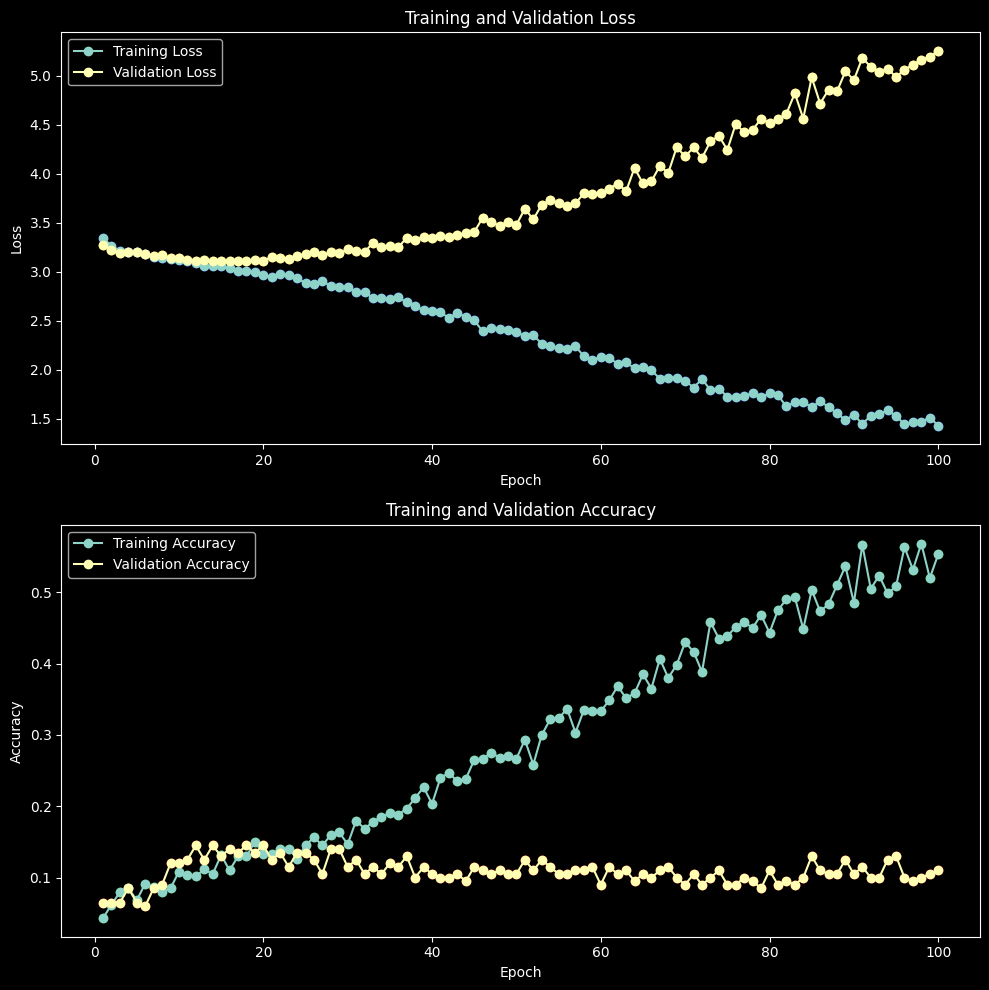

In [117]:
generate_plots(train_losses, val_losses, train_accuracies, val_accuracies)